# Decision Trees

In [1]:
%matplotlib notebook
import numpy as np
from sklearn import tree
from sklearn.datasets import load_iris
import matplotlib.pyplot as plt
from IPython.display import Image

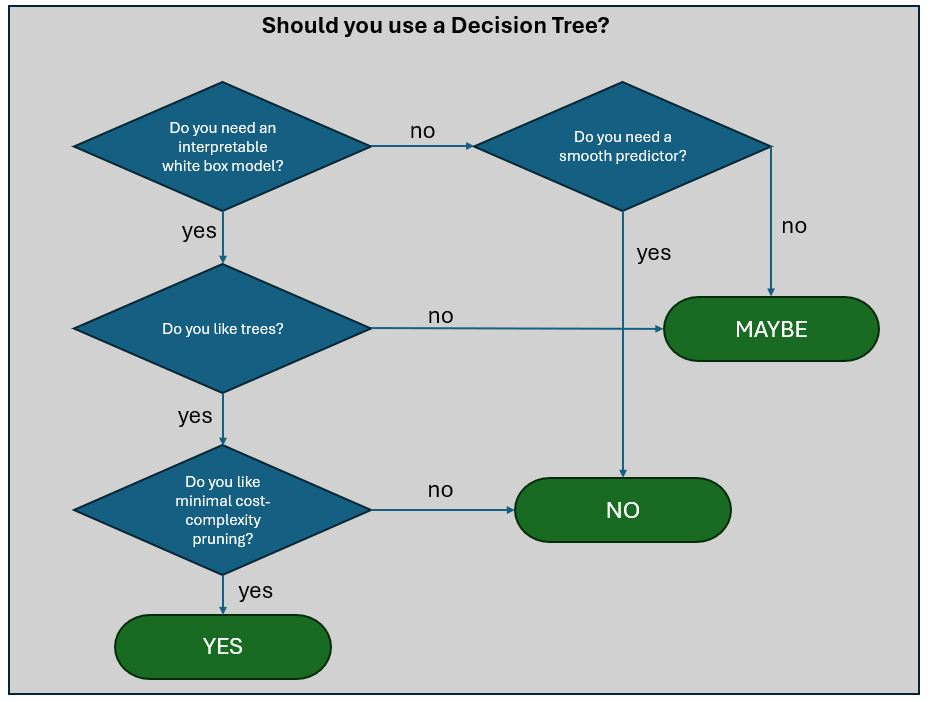

In [2]:
Image(filename='decision_tree.jpg')

Decision trees are based on a very intuitive principle: Say you have some continuous data $X$ with only one feature labeled into two classes $y \in \{-1,1\}$ and you want to classify a new data point $x^* \in \mathbb{R}$. Then using the data $X$ you have got, you work out a threshold $t$ and then you set
\begin{align*}
    \hat f(x^*) := 
   \begin{cases}
       -1, & x^* \leq t, \\
       1, & x^* > t.
   \end{cases}
\end{align*}
In case the data has more than one feature, we can always select one feature first, work out a threshold, and then conditional on the first feature and threshold, repeat the process with the second feature and so on. This creates a tree structure where we make decisions based on thresholds, which gives this model its name.

## Formal definitions
To make this idea precise, we first need to define what a tree is, second how to calculate the thresholds from the data set, and third how to use this to classify new data. 

### Graph Theory Reminder
**Definition (undirected graph):** An *(undirected) graph* is a tuple $G=(V,E)$, where the *vertices* $V$ are a set and the *edges* $E$ are a set of two-element subsets of $V$. 

**Definition (adjacent, path):** Let $G=(V,E)$ be a graph. Any two vertices $v_1,v_2 \in V$ are *adjacent*, $v_1 \sim v_2$, if $\{v_1, v_2\} \in E$. A *path* is an ordered list $v_1 ~ v_2 ~ \ldots ~ v_k$ of adjacent vertices.

**Definition (tree):** A graph $G=(V,E)$ in which any two nodes can be connected with precisely one path is called a *tree*. The tree is *rooted*, if one node is designated as the *root* $v_0$. For rooted trees:
* For any other node $v_1 \neq v_0$, the uniquely determined node $v_p \in V$ adjacent to $v_1$ on the path from $v_1$ to $v_0$ is called its *parent*. Any node on that path is called an *ancestor* of $v_1$.
* All nodes $v$, for which $v_p$ is a parent, are called *children* of $v_p$. 
* A node that has no children is called a *leaf* and we denote by $V_{\text{leaf}} \subset V$ the leaves. 
* All nodes on a path between $v$ and a leaf are called *descendants* of $v$.
* A tree in which every node has at most $k$ children is called *$k$-ary*. In case $k=2$, $G$ is called a *binary tree*. 
* The *depth* of a node is the length of the unique path from the node to the root. The *depth* of the graph is the longest depth of any node. 


### Extensions to decision trees
**Definition (decision function):** Let $G=(V,E)$ be a binary rooted tree. For any vertex $v \in V$ that is not a leaf denote by $v_-,v_+ \in V$ its uniquely determined children. A *vertex decision function* for $v$ is a function $f_v:\mathbb{R}^d \to \{v_-,v_+\} \subset V$. 

**Definition (leaf function)**: Let $G=(V,E)$ be a binary rooted tree and for each $v \in V$ that is not a leaf, let $f_v: \mathbb{R}^d \to V$ be a decision function. For any data point $x^* \in \mathbb{R}^d$, the *leaf function* $f:\mathbb{R}^d \to V$ is defined inductively as follows: Let $v_0 \in V$ be the root of the tree. Then $f_0(x^*) := f_{v_0}(x^*)$. Now, for any $i \in \mathbb{N}$, if $f_i(x^*)$ is a leaf, then $i^*:= i^*(x^*) := i$ and we finish. If $f_i(x^*)$ is not a leaf, then $f_{i+1}(x^*) := f_{f_i(x^*)}(x^*)$ and we repeat this until we reach a leaf. Finally, we define
\begin{align*}
    f(x^*) := (f_{i^*} \circ \ldots \circ f_1 \circ f_0)(x^*)
\end{align*}
to be the *leaf* of $x^*$. We call the vertices $v_0, v_1, \ldots, v_{i^*}$ the *decision path* of $x^*$.

# Fitting a tree
Let $(X,y)$ be a labelled dataset with $x_i \in \mathbb{R}^d$, $i=1, \ldots, N$, and $y_i \in \mathbb{R}^l$. How can we use such a data set to construct a decision tree with its decision functions? The basic idea is to start the tree at the root, associate all samples to the root, and then successively split the data into more and more child nodes using a criterion to construct the decision functions in each step. The principle is the same for classification and regression, but the details are a bit different. Before we delve into the details, we should introduce some notation on how to populate a decision tree with data.

**Definition (tree splitting data sets):** Let $(X_i,y_i)$, $i=1, \ldots, N$, be a data set and $G=(V,E)$ be a binary rooted tree with root $v_0$. For each vertex $v \in V$, let $I_v \subset \{1, \ldots, N\}$ be an index set associating a subset of samples to the vertex $v$. We say the tree $G$ *splits the data set*, if $I_{v_0}=\{1, \ldots, N\}$, i.e. all data is attached to the root, and for every vertex $v$ that is not a leaf, $I_v = I_{v^+} \dot \cup I_{v^-}$. If $f_v$ are decision functions on the tree, we say the split is *given by decision functions* if for any vertex $v$ that is not a leaf, $I_{v^\pm} = \{i \mid f_v(x_i)=v^{\pm}\}$.

## Impurity functions for classification
Recall that for classification we assume that the labels satisfy $y_i \in \{1, \ldots, K\}$, $i=1, \ldots, N$. If a decision tree is splitting a data set, then each node $v$ has some sub set of samples $y_{I} := y_{I_v} := \{y_i \mid i \in I_v\}$. We can convert that subset of samples into an empirical distribution via
\begin{align*}
    \forall 1 \leq k \leq K: p_k(v) := p_k(I) := \frac{N_k(I)}{N(I)}, && N_k(I) := |\{i \mid i \in I, y_i = k\}|, && N(v) := |I|.
\end{align*}
The resulting vector $p(v)$ is a probability vector. Here is the definition again of this important notion:

**Definition (probability vector):** A vector $p=(p_1, \ldots, p_k) \in \mathbb{R}^k$ is a *probability vector* if
\begin{align*}
    \forall 1 \leq j \leq K: p_j \geq 0, &&  \sum_{j=1}^{K}{p_j}=1.
\end{align*}
We denote by $\mathcal{P}_K$ the set of probability vectors of length $K$. 

Now, the key notion is as follows:

**Definition (pure):** A probability vector $p$ is called *pure* if all entries are zero, except one entry that is one. A sample set $y_I$ is called *pure* if the probability vector of its empirical distribution is pure.

What we would like to have is a decision tree that splits the data in a way that all the leaves are pure, because this would allow us to to easily classify all data in those leaves. However, in practice it is unlikely to easily achieve this perfectly. Hence, we introduce the notion of impurity to measure how far away we are from such a situation and then use this measure of impurity to try to construct our decision functions with the aim of reducing this impurity in every step.

An *impurity function* $g$ is a function defined on all $\mathcal{P}_K$ such that the following conditions hold:
* Maximum: $g$ attains its minimum only on the uniform distribution, i.e.
\begin{align*}
    \forall K \in \mathbb{N}: p = \operatorname{argmax}_{p' \in \mathcal{P}_K} g(p') \Leftrightarrow \forall 1 \leq j \leq K: p_j = \frac{1}{K}.
\end{align*}
* Minimum: $g$ attains its minimum only on pure probability vectors.
* Symmetry: $g$ is symmetric, i.e. for any $K$ and any permutation $\tau$:
\begin{align*}
    \forall (p_1, \ldots, p_K) \in \mathcal{P}_K: g(\tau(p_1), \ldots, \tau(p_K)) = g(p_1, \ldots, p_K).
\end{align*}
* Concavity: The function $g$ is concave, i.e. for any $p,q \in \mathcal{P}_K$ and any $0 \leq \lambda \leq 1$
\begin{align*}
    g(\lambda p + (1-\lambda)q) \geq \lambda g(p) + (1-\lambda)g(q).
\end{align*}

Most famous examples of impurity functions are as follows:

**Definition (Gini impurity / Entropy / Missclassification):** Let $p \in \mathcal{P}_K$ be a probability vector. Then 
\begin{align*}
    g(p) := \sum_{k=1}^{K}{p_{k}(1-p_{k})} = 1 - \sum_{k=1}^{K}{p_{k}^2}
\end{align*}
is called *Gini impurity*, 
\begin{align*}
    h(p) := - \sum_{k=1}^{K}{p_{k}\log(p_{k})}
\end{align*}
is called *log-loss* or *entropy*, and
\begin{align*}
    r(p) := 1 - \max_{1 \leq j \leq k}{p_j},
\end{align*}
is the *(majority class) misclassification rate*.

A proof that these functions satisfy the definition of impurity functions is given in the appendix.

**Example:** The usefulnes of these notions can be understood by considering a binary classification problem, i.e. $K=2$, and plotting the Gini impurity of $N=100$ samples in the case where $0 \leq k \leq N$ of them are of class $k=1$:

<IPython.core.display.Javascript object>


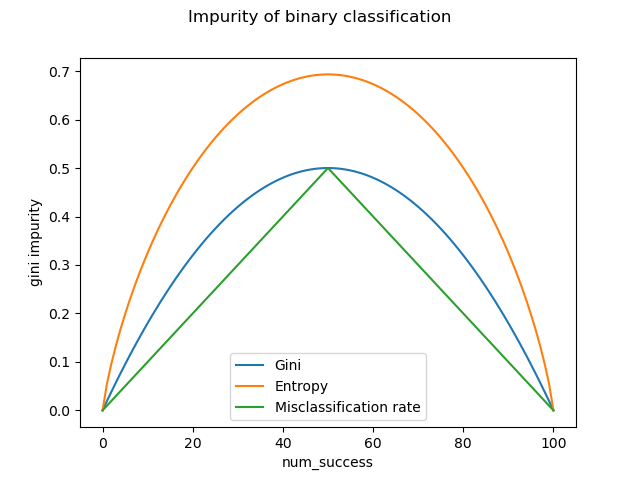

In [3]:
n = 100
n_success = np.arange(0, n+1)
n_failure = n - n_success
p_success = n_success / n
p_failure = 1 - p_success
gini =  p_success * (1-p_success) + p_failure * (1-p_failure)
entropy = np.zeros(n+1)
entropy[1:-1] = -(p_success[1:-1] * np.log(p_success[1:-1]) + p_failure[1:-1] * np.log(p_failure[1:-1]))
missclass = np.zeros(n+1)
missclass[:50] = 1 - n_failure[:50] / n
missclass[50:] = 1 - n_success[50:] / n
plt.figure()
plt.suptitle('Impurity of binary classification')
plt.plot(n_success, gini, label='Gini')
plt.plot(n_success, entropy, label='Entropy')
plt.plot(n_success, missclass, label='Misclassification rate')
plt.xlabel('num_success')
plt.ylabel('gini impurity')
plt.legend()
plt.show()

We can see that all both impurity measures, the value at the ends, where the data is pure, is zero and then increases toward the middle. The maximum is attained at $p_{\text{success}}=50\%$ where the classes are maximally mixed.

## Fitting with impurity functions

The key insight is that due to the convexity of the impurity function, splitting any sample into two, reduces impurity. We need one convention to formulate this:

**Definition:** Let $y_I = (y_{i_1}, \ldots, y_{i_n})$ be any sample. Then the impurity of the sample is defined as the impurity of its empirical distribution, i.e.
\begin{align*}
    g(y_I) := g(p(I)), && p_k(I) := \frac{N_k(I)}{N(I)}, && N_k(I) := \frac{|\{i \in I \mid y_i = k\}|}{|I|}.
\end{align*}

**Lemma (split reduces impurity):** Let $I=I^+ \dot \cup I^-$ be any index set split into two disjoint subsets and $y_I$ be any sample of $K$ classes and $g$ be any impurity function. Then
\begin{align*}
    g(y_I) \geq \frac{|I^+|}{|I|} g(y_{I^+}) + \frac{|I^-|}{|I|} g(y_{I^-})
\end{align*}

**Proof:** This follows simply from the convexity of $g$ using $\lambda := \frac{|I^+|}{|I|}$.

While any split has a non-increasing impact on the resulting impurity, not every split has the same impact. Thus, it is only natural to ask, which split results in the biggest reduction.

**Definition (impurity minimal):** Let $G=(V,E)$ be a binary rooted tree and for each $v \in V$ that is not a leaf, let $f_v: \mathbb{R}^d \to V$ be a decision function and $I_v$ the set of all $i$ such that the leaf path of $x_i$ crosses $v$. We call the decision functions $f_v$ *impurity minimal* with respect to an impurity function $g$ if for any $v$ that is not a leaf, the following condition holds: There exist $(j_v,t_v)$, $1 \leq j \leq d$, $t_v \in \mathbb{R}$ such that for all $i \in I_v$
\begin{align*}
    f_v(x_i) = \begin{cases}
        v_- & x_{i,j} \leq t_v \\
        v_+ & x_{i,j} > t_v \\
    \end{cases}
\end{align*}
and the weighted impurity
\begin{align*}
    g_v(j_v,t_v) := \frac{|I_{v_+}|}{|I_v|} g(y_{I_{v_+}}) + \frac{|I|}{|I_{v_-}|} g(y_{I_{v_-}})
\end{align*}
is minimal amongst such choices, i.e.
\begin{align*}
    (j_v, t_v) = \operatorname{argmin}_{j,t}g_v(j,t).
\end{align*}

This leads to the following construction of decision trees:

**Algorithm:** Let $(X,y)_i$, $i=1, \ldots, N$, be a data set, let $y_i \in \{1, \ldots, K\}$, let $g$ be an impurity function and let $\min_{\text{samples}}, \max_{\text{depth}} \in \mathbb{N}$. Then we can construct impurity minimal decision functions as follows: 
* Let $l := 0$ and define $G_l := (V_l, E_l) := (\{v_0\}, \emptyset)$ and set $I_{v_0}:=\{1, \ldots, N\}$, i.e. associate all data with the root. Set $L := \{v_0\}$.
* While $L \neq \emptyset$ proceed inductively as follows:
  * Take any $v \in L$ and remove it from the set $L$.
  * Compute 
    \begin{align*}
        (j_{v}, t_v) = \operatorname{argmin}_{j,t}g_v(j,t)    
    \end{align*}
    and let $f_v$ be the resulting minimal impurity decision function.
   * If a stopping criterion, see below, is satisfied ignore the node and proceed to the next iteration.
   * If not, then create two more leaves $v^+$ and $v^-$ and set $l \rightarrow l+1$ and create $G_{l+1}:=(V_{l+1},E_{l+1})$ where $V_{l+1} := V_l \cup \{v\}$ and $E_{l+1} := E_l \cup \{ \{v, v^+\}, \{v, v^-\}\}$ and set $I_{v^{\pm}} := \{i \in I_v \mid f_v(x_i))=v^{\pm} \}$.


Stopping Criterion: One can define various stopping criterions. Popular choices are
  * If $|I_{v_+}|<\min_{\text{samples}}$ or $|I_{v_-}|<\min_{\text{samples}}$ for a pre-specified number $\min_{\text{samples}}$, then we stop for that node $v$.
  * If the depth of $v$ equals a pre-specified threshold, we stop.
  * If the reduction in impurity from $v$ to $v^{\pm}$ is too small, we stop.

The precise nature of stopping criterion and this algorithm can vary - popular versions are called: ID3, C4.5, C5.0 and CART.

## Error functions for regression
If we want to use the tree for regression instead of classification, we can use the exact same principle, but because the labels $y_i$ are continuous in this case, we have to replace the impurity functions by error functions. Popular choices are:

**Definition (error functions for regression):**
* Mean Squared Error (MSE): 
\begin{align*}
    g(y) := \sum_{i=1}^{k}{(y_i - \bar y)}, && \bar y := \frac{1}{k} \sum_{i=1}^{k}{y_i}.
\end{align*}
* Half Poisson Distance: (in case all $y_i \geq 0$)
\begin{align*}
    g(y) := \sum_{i=1}^{k}{\Big(y_i \frac{\log(y_i)}{\bar y} -y_i + \bar y \Big)}, && \bar y := \frac{1}{k} \sum_{i=1}^{k}{y_i}.
\end{align*}
* Mean Absolute Deviation:
\begin{align*}
    g(y) := \sum_{i=1}^{k}{|y_i - \check y|},
\end{align*}
where $\check y$ is the median of the $y_1, \ldots, y_k$.

# Predictions
The last ingredient needed to construct a decision tree is how to make predictions. These are done using scoring function $\delta:V_{\text{leaf}} \to [0,1]$ on each leaf $v$. This finally gives a decision tree. The scoring functions need to be constructed slightly differently for classifiers than for regressors.

**Definition (decision tree classifier):** A tuple $(G=(V,E), (f_v)_{v \in V \setminus V_{\text{leaf}}}, (\delta_{k})_{1 \leq k \leq K} )$ is called a *decision tree classifier* on $\mathbb{R}^d$ with classes $\{1, \ldots, K\}$, if $G$ is a rooted binary tree, $V_{\text{leaf}}$ is the set of leaf nodes, $f_v$ are decision functions and $\delta_{k}:V_{\text{leaf}} \to [0,1]$ are *scores* satisfying
\begin{align*}
    \forall v \in V_{\text{leaf}}: \sum_{k=1}^{K}{\delta_{k}(v)} = 1.
\end{align*}
The classifier $\hat f: \mathbb{R} \to \{1, \ldots, K\}$ of the decision tree is given by
\begin{align*}
    \hat f(x) = \operatorname{argmax}_{1 \leq k \leq K}{\delta_{k}(f(x))},
\end{align*}
where $f(x)$ is the leaf function. 

The most popular scoring function is simply:
\begin{align*}
    \forall v \in V_{\text{leaf}}: \delta_{k}(v) := \frac{|\{i \in I_v \mid y_i = k\}|}{|I_v|}.
\end{align*}

For regression this is very similar:

**Definition (decision tree regressor):** A tuple $(G=(V,E), (f_v)_{v \in V \setminus V_{\text{leaf}}}, \delta)$ is called a *decision tree regressor* on $\mathbb{R}^d$, if $G$ is a rooted binary tree, $V_{\text{leaf}}$ is the set of leaf nodes, $f_v$ are decision functions and $\delta:V_{\text{leaf}} \to \mathbb{R}^l$ are any functions called *prediction functions*. 
The regressor $\hat f: \mathbb{R} \to \mathbb{R}^l$ of the decision tree is given by
\begin{align*}
    \hat f(x) = \delta(f(x)).
\end{align*}
where $f(x)$ is the leaf function. 

The most popular prediction function is simply the average:
\begin{align*}
    \forall v \in V_{\text{leaf}}: \delta(v) := \frac{1}{|I_v|}\sum_{i \in I_v}{y_i}.
\end{align*}

# Minimal Cost-Complexity Pruning
Choosing a stopping criterion is a possible method to stop the tree from growing too big and hence overfit the data. A very effective alternative (or complimentary) method is to let the tree grow big and then prune it later. A popular choice is to regularize the cost function by a complexity measure and gradually prune parts of the tree.

The first step is to introduce a measure of cost that evaluates the whole tree. An obvious choice is to take the sample-weighted cost function on the leaves, i.e.
\begin{align*}
    R(G) := \sum_{v \in V_{\text{leaf}}}{g(v)p(v)},
\end{align*}
here $g(v)$ is an impurity function and $p(v)$ is the fraction of samples at $v$. While in  [popular textbook theory](https://online.stat.psu.edu/stat508/lesson/11/11.8), the impurity function is often chosen as the misclassification rate, [popular implementations](https://scikit-learn.org/stable/modules/tree.html#minimal-cost-complexity-pruning) rely on using the Gini impurity instead.

Because the cost measure never increases when the tree grows, we also need a measure of complexity. An obvious choice is $|G| := |V_{\text{leaf}}|$, i.e. the number of leaf nodes in the tree. Because this measure of complexity cannot be naturally compared with the measure of cost, we need to weigh it using some parameter $\alpha \geq 0$, i.e.
\begin{align*}
    R_{\alpha}(G) := R(G) + \alpha |G|.
\end{align*}

## Weakest Link Cutting
Let $G$ be a decision tree. We want to gradually prune the tree in a way that achieves a trade off between cost and complexity. Before we start, notice that it is possible that there are leaf nodes $v^+, v^-$ of a parent $v$ such that $g(v) = R(v)$, i.e. the impurity at the node is the same as the weighted impurity of the leaves. In that case, we simply prune away the child nodes $v^+$ and $v^-$ resulting in a new tree $G'$. We repeat this process until we arrive at a tree $G_1$, where the parents $v$ of any leaf node satisfies $g(v) > R(v)$, i.e. the split leads to an actual cost reduction.

Now, for any remaining node $v \in G_1$ that is not a leaf, we can pretend it were a leaf and define its cost-complexity by $R_{\alpha}(v) := g(v) + \alpha |\{v\}| = g(v) + \alpha$. The subtree $G_v$ of $G$ comprising of all the descendants of $v$, i.e. in which $v$ is the root, has cost-complexity $R_{\alpha}(G_v)$. Because the cost measure is non-increasing, we have $R(G_v) < R(v)$. However, the complexity measure clearly satisfies of $|G_v|>|v|=1$. Thus, for the weighted cost-complexity measure, $R_0(G_v) < R_0(v)$ for $\alpha=0$, but if we now gradually increase $\alpha$, there will be a point, where they are equal. This is called the *effective alpha of $v$* and is given by
\begin{align*}
    R_{\alpha}(G_v) = R_{\alpha}(v) 
    \Longleftrightarrow R(G_v) + \alpha |G_v| = g(v) + \alpha
    \Longleftrightarrow R(G_v) - g(v)  = - \alpha (|G_v| - 1)
    \Longleftrightarrow \frac{g(v) - R(G_v)}{|G_v| - 1}  = \alpha=:\alpha_{\text{eff}}(v)
\end{align*}

Weakest link cutting hence calculates the $\alpha_{\text{eff}}$ of all the nodes that are not the leaves and cuts the weakest one, i.e. the one with the smallest $\alpha_{\text{eff}}$. This continues until all remaining nodes have $\alpha_{\text{eff}} > \alpha_{\text{eff},\text{max}}$, which is a parameter that needs to be specified, see [for example the `ccp_alpha` here](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html).

One [can show](https://online.stat.psu.edu/stat508/lesson/11/11.8/11.8.2) that this weakest link cutting leads to an increasing subgraph that is being cut-off, i.e. the nodes cut off at an $\alpha_1 < \alpha_2$ are contained in the ones that are cut-off at $\alpha_2$. 

# Examples

## Iris Classification
The iris data set contains $n=150$ samples with $d=4$ features representing the sepal and petal lengths and widths of $K=3$ different types of irises.

In [20]:
iris = load_iris()
X, y = iris.data, iris.target
clf = tree.DecisionTreeClassifier(ccp_alpha=0)  # try: 0.05
clf = clf.fit(X, y)

<IPython.core.display.Javascript object>


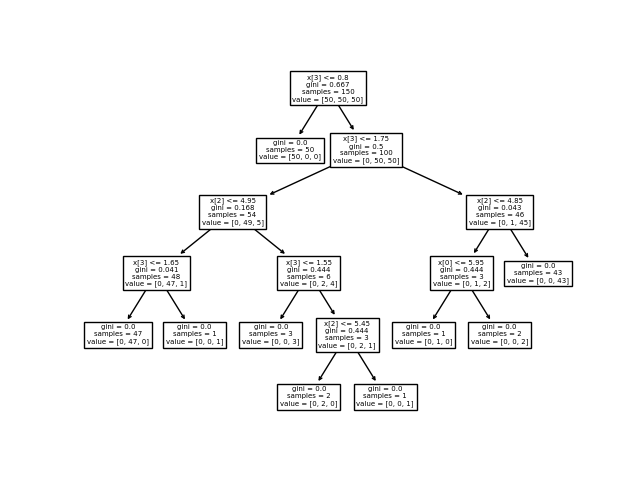

In [21]:
# plot fitted tree
plt.figure()
tree.plot_tree(clf)
plt.show()

In [22]:
# text representation
print(tree.export_text(clf))

|--- feature_3 <= 0.80
|   |--- class: 0
|--- feature_3 >  0.80
|   |--- feature_3 <= 1.75
|   |   |--- feature_2 <= 4.95
|   |   |   |--- feature_3 <= 1.65
|   |   |   |   |--- class: 1
|   |   |   |--- feature_3 >  1.65
|   |   |   |   |--- class: 2
|   |   |--- feature_2 >  4.95
|   |   |   |--- feature_3 <= 1.55
|   |   |   |   |--- class: 2
|   |   |   |--- feature_3 >  1.55
|   |   |   |   |--- feature_2 <= 5.45
|   |   |   |   |   |--- class: 1
|   |   |   |   |--- feature_2 >  5.45
|   |   |   |   |   |--- class: 2
|   |--- feature_3 >  1.75
|   |   |--- feature_2 <= 4.85
|   |   |   |--- feature_0 <= 5.95
|   |   |   |   |--- class: 1
|   |   |   |--- feature_0 >  5.95
|   |   |   |   |--- class: 2
|   |   |--- feature_2 >  4.85
|   |   |   |--- class: 2



In [23]:
# format of the training set
X.shape, y.shape

((150, 4), (150,))

In [24]:
# root of the tree has index 0
# we can retrieve information about the split at zero
print(f"Number of samples on that node: {clf.tree_.n_node_samples[0]}")
print(f"Feature used for splitting: {clf.tree_.feature[0]}")
print(f"Threshold for splitting: {clf.tree_.threshold[0]}")
print(f"Impurity: {clf.tree_.impurity[0]}")
print(f"Number of samples in node, output and class: {[clf.tree_.value[0, 0, k] for k in range(3)]}")

Number of samples on that node: 150
Feature used for splitting: 3
Threshold for splitting: 0.800000011920929
Impurity: 0.6666666666666667
Number of samples in node, output and class: [50.0, 50.0, 50.0]


In [25]:
# we can get the id of the children of the root:
print(f"Left Child: {clf.tree_.children_left[0]}")
print(f"Right Child: {clf.tree_.children_right[0]}")
# with this information we could iterate through the whole tree, but let's just check the two children as well

Left Child: 1
Right Child: 2


In [26]:
# e.g. left child of root
print(f"Number of samples on that node: {clf.tree_.n_node_samples[1]}")
print(f"Feature used for splitting: {clf.tree_.feature[1]}")
print(f"Threshold for splitting: {clf.tree_.threshold[1]}")
print(f"Impurity: {clf.tree_.impurity[1]}")
print(f"Number of samples in node, output and class: {[clf.tree_.value[1, 0, k] for k in range(3)]}")

Number of samples on that node: 50
Feature used for splitting: -2
Threshold for splitting: -2.0
Impurity: 0.0
Number of samples in node, output and class: [50.0, 0.0, 0.0]


In [27]:
# depth of the tree
print(clf.tree_.max_depth)

5


In [28]:
# calculate the node id of the leaf in which the data points end up in
clf.apply(X)

array([ 1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  5,
        5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,
        5,  5, 14,  5,  5,  5,  5,  5,  5, 10,  5,  5,  5,  5,  5, 10,  5,
        5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5, 16, 16,
       16, 16, 16, 16,  6, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16,
        8, 16, 16, 16, 16, 16, 16, 15, 16, 16, 11, 16, 16, 16,  8,  8, 16,
       16, 16, 15, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16],
      dtype=int64)

In [29]:
# for each data point we can obtain an indicator vector, which for every node, indicates if the decision path crosses through that node
I = clf.decision_path(X).toarray()
print(I.shape)  # (num_samples, num_nodes)
I

(150, 17)


array([[1, 1, 0, ..., 0, 0, 0],
       [1, 1, 0, ..., 0, 0, 0],
       [1, 1, 0, ..., 0, 0, 0],
       ...,
       [1, 0, 1, ..., 0, 0, 1],
       [1, 0, 1, ..., 0, 0, 1],
       [1, 0, 1, ..., 0, 0, 1]], dtype=int64)

In [30]:
# this allows us to calculate for each node, which sample is attached to it
num_nodes = I.shape[1]
samples_at_node = {i: X[I[:,i].astype(bool), :] for i in range(num_nodes)}

# example
samples_at_node[5].shape

(47, 4)

In [31]:
# reconcile example decision path
i = 100  # index of sample
leaf_id = clf.apply(X[i, :][np.newaxis, :])[0]  # this is the leaf where it should end up
index_val = np.zeros(num_nodes, dtype=int)  # tally visited node ids
current_id = 0  # start at root
while current_id != leaf_id:  # traverse decision path
    index_val[current_id] = 1  # mark node as visited
    current_feature = clf.tree_.feature[current_id]
    current_threshold = clf.tree_.threshold[current_id]
    if X[i, current_feature] <= current_threshold:  # check if we go left or right
        current_id = clf.tree_.children_left[current_id]
    else:
        current_id = clf.tree_.children_right[current_id]
index_val[current_id] = 1  # add last index

# reconcile path
np.testing.assert_array_equal(index_val, I[i, :])

## Sine Regression

In [32]:
np.random.seed(1)
X = np.sort(np.random.uniform(-3, 3, 20))
y = np.sin(X)
X=X[:,np.newaxis]

In [33]:
reg = tree.DecisionTreeRegressor()
reg.fit(X,y)

DecisionTreeRegressor()

In [34]:
X_pred = np.linspace(-3,3, 200)[:, np.newaxis]
y_pred = reg.predict(X_pred).squeeze()

<IPython.core.display.Javascript object>


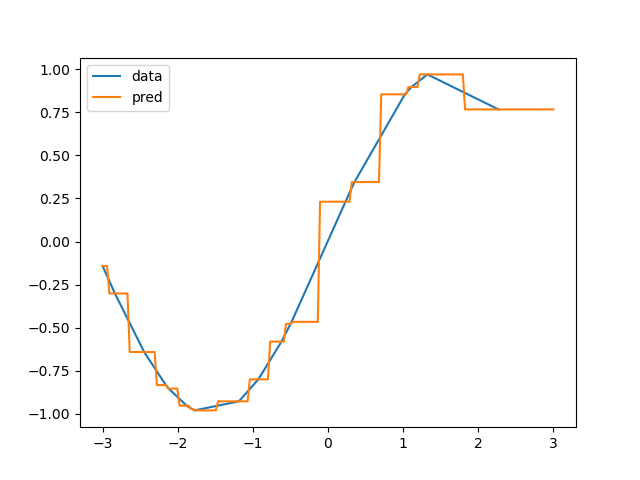

In [35]:
plt.figure()
plt.plot(X.squeeze(), y, label='data')
plt.plot(X_pred.squeeze(), y_pred, label='pred')
plt.legend()
plt.show()

# Appendix

## Impurity Functions

**Lemma:** The Gini impurity, the entropy and the misclassification rate satisfy the axioms of an impurity function.

**Proof (Gini):** Notice that a neccessary condition for an extremal point $p \in \mathbb{R}^K$ is that it satisfies the constraint 
\begin{align*}
    c(p) := \sum_{j=1}^{K}{p_k} - 1 = 0 && \Longrightarrow && \nabla c(p) = (1, \ldots, 1) =: \mathbf{1}
\end{align*}
and hence for the Gini impurity
\begin{align*}
    g(p) = \sum_{k=1}^{K}{p_{k}(1-p_{k})} = \sum_{k=1}^{K}{p_{k}} - \sum_{k=1}^{K}{p_{k}^2} 
\end{align*}
to satisfy the Lagrange equation
\begin{align*}
    \nabla g (p) = \lambda \nabla c(p) 
    && \Longleftrightarrow \mathbf{1} - 2 p = \lambda \mathbf{1} &&
    && \Longleftrightarrow  p = \frac{1 - \lambda}{2} \mathbf{1},
\end{align*}
which implies that all entries of $p$ must have the same value. The condition $h(p)=0$ implies that this can only be the case if $p$ is the uniform distribution. The extremal value is hence given by
\begin{align*}
    g(\tfrac{1}{K}, \ldots, \tfrac{1}{K}) 
    = \sum_{k=1}^{K}{\frac{1}{K}} - \sum_{k=1}^{K}{\frac{1}{K^2}}
    = 1 - \frac{1}{K}.
\end{align*}
The only other extremal values can be at the boundary. Let $e_k = (0, \ldots, 0, 1, 0, \ldots, 0)$ be the pure vector of class $k$. Then
\begin{align*}
    g(e_k) = 1 - 1 = 0.
\end{align*}
This proves that $g$ has a maximum at the uniform distribution and minima at the pure vectors. Given that
\begin{align*}
    \forall 1 \leq i \leq n: \frac{\partial^2 g}{\partial p_i p_i} &= - 2, \\
    \forall 1 \leq i \neq j \leq n: \frac{\partial^2 g}{\partial p_i p_j} &= 0,
\end{align*}
we have $\nabla^2 g(\tfrac{1}{k}\mathbf{1}) = -2 I$ and is hence negative-definite. Therefore, $g$ is concave.

**Proof (Entropy):** For the entropy, we calculate in a similar fashion:
\begin{align*}
    \frac{\partial h}{\partial p_j} = - \log(p_j) - 1
\end{align*}
and hence for any $1 \leq j \leq K$, the Lagrange equation reads
\begin{align*}
    - \log(p_j) - 1 = \lambda \; \Longleftrightarrow \; \log(p_j) = \lambda - 1
\end{align*}
and hence all $p_j$ must be constant. It follows again that the uniform distribution is the only critical point. Its value is
\begin{align*}
    h(\tfrac{1}{K}, \ldots, \tfrac{1}{K}) 
    = - \sum_{k=1}^{K}{\frac{1}{K} \log(k^{-1})}
    = \log(K)
\end{align*}
and the value on any pure vector is
\begin{align*}
    h(0, \ldots, 0, 1, 0, \ldots, 0) = 0,
\end{align*}
thus $h$ attains its maximum at the uniform distribution and has minima at the boundary on pure vectors. Furthermore, since
\begin{align*}
    \forall 1 \leq i \leq K: \frac{\partial^2 h}{\partial_i \partial_i}(p) & = - \frac{1}{p_i} \\
    \forall 1 \leq i \neq j \leq K: \frac{\partial^2 h}{\partial_i \partial_j}(p) & =0,
\end{align*}
hence $\nabla^2 h$ is negative-definite, thus $h$ is concave.

**Proof (Misclassification):** Note that for any $p \in \mathcal{P}_K$, we have $\max_{1 \leq k \leq K}{p_k} \geq \tfrac{1}{K}$. If this were not the case then $\sum_{k=1}^{K}{p_k} \leq K \max_{1 \leq k \leq K}{p_k} < K \tfrac{1}{K} = 1$, which contradicts the definition of a probability vector. Hence, we obtain
\begin{align*}
    r(p) = 1 - \max_{1 \leq k \leq K}{p_k} \leq 1 - \tfrac{1}{K} = r(\tfrac{1}{K}, \ldots, \tfrac{1}{K}),
\end{align*}
hence $r$ has a maximum at the uniform distribution. Also
\begin{align*}
    r(p)  = 1 - \max_{1 \leq k \leq K}{p_k} \geq 0 = r(0, \ldots, 0, 1, 0, \ldots,0),
\end{align*}
hence $r$ has minima at pure vectors. To see that it is concave, let $0 \leq \lambda \leq 1$ and note that for any two $p,q \in \mathcal{P}_K$, we have
\begin{align*}
    \max_{1 \leq k \leq K}{\lambda p_k + (1-\lambda)q_k} 
    \leq \lambda \max_{1 \leq k \leq K}{p_k} + (1-\lambda) \max_{1 \leq k \leq K}{q_k}  
\end{align*}
and hence

\begin{align*}
    r(\lambda p_k + (1-\lambda)q_k) 
    & = 1 - \max_{1 \leq k \leq K}{\lambda p_k - (1-\lambda)q_k} \\
    &\geq 1 -  \lambda \max_{1 \leq k \leq K}{p_k} - (1-\lambda) \max_{1 \leq k \leq K}{q_k}  \\
    &\geq \lambda -  \lambda \max_{1 \leq k \leq K}{p_k} + (1-\lambda) - (1-\lambda) \max_{1 \leq k \leq K}{q_k}  \\
    &\geq \lambda r(p) + (1-\lambda)r(q),
\end{align*}
hence $r$ is concave.

# Sources & References
* https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html
* https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeRegressor.html
* https://scikit-learn.org/stable/modules/tree.html
* https://scikit-learn.org/stable/auto_examples/tree/plot_unveil_tree_structure.html#sphx-glr-auto-examples-tree-plot-unveil-tree-structure-py
* https://online.stat.psu.edu/stat508/lesson/11/11.8